##**Hardware Setting**


In [2]:
!nvidia-smi

Wed Nov 30 21:31:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd /content/drive/MyDrive/Facial Emotion Recognition/FER2013_pixel

[Errno 2] No such file or directory: '/content/drive/MyDrive/Facial Emotion Recognition/FER2013_pixel'
/content


In [ ]:
#! pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
#! mkdir ~/.kaggle

In [ ]:
#! cp kaggle.json ~/.kaggle/

In [ ]:
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list

In [ ]:
#!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge


In [ ]:
#!unzip challenges-in-representation-learning-facial-expression-recognition-challenge


In [ ]:
#!tar -xvf  'fer2013.tar.gz' -C 'Dataset'


##**Import Libraries**

In [66]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import np_utils
import scikitplot
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings("ignore")

##**Dataset**

In [9]:
data = pd.read_csv("/content/drive/MyDrive/Facial_Emotion_Recognition/Dataset/fer2013/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

##**Dataset Distribution**

Text(0.5, 1.0, 'Emotion Distribution')

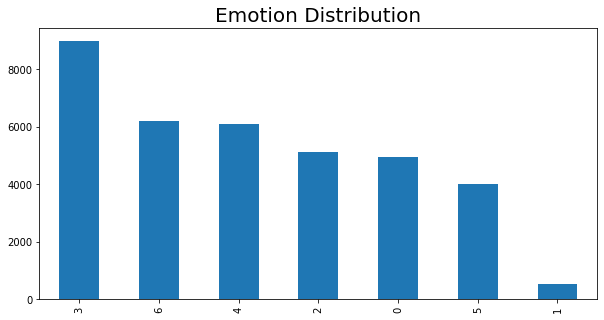

In [11]:
data['emotion'].value_counts().plot.bar(figsize=(10,5))
plt.title('Emotion Distribution',fontsize=20)

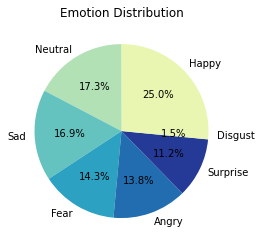

In [12]:
emotions_pie = {3: 'Happy',6: 'Neutral',  4: 'Sad', 2: 'Fear',0: 'Angry',   5: 'Surprise',1: 'Disgust' }

import seaborn as sns
colors = sns.color_palette('YlGnBu')
plt.pie(data['emotion'].value_counts(), 
      labels = emotions_pie.values(), 
        autopct = '%1.1f%%',
       # startangle =90,
        colors=colors
        )
plt.title('Emotion Distribution')
plt.show()


## **Upsampling**

In [13]:
print((data[data['emotion']==3]).shape)

(8989, 3)


In [14]:
from sklearn.utils import resample
majority = data[(data['emotion']==3)] 
minority = data[(data['emotion']==6)] 
majority_downsampled = resample(majority, 
                                 replace=True,    
                                 n_samples=6198,     
                                 random_state=123) 
 

#downsampled = pd.concat([majority_downsampled, minority])

In [15]:
print(majority_downsampled.shape)

(6198, 3)


In [16]:
from dataclasses import replace
index = data[(data['emotion'] == 3)].index
data.drop(index, inplace=True)

In [17]:
data['emotion'].value_counts()

6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [18]:
data = pd.concat([majority_downsampled, data])

In [19]:
data['emotion'].value_counts()

3    6198
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

##**Downsampling**

In [20]:
print((data[data['emotion']==6]).shape)

(6198, 3)


In [21]:
from sklearn.utils import resample
majority = data[(data['emotion']==6)] 
minority = data[(data['emotion']==1)] 

minority_upsampled = resample(minority, 
                                 replace=True,   
                                 n_samples= 6198, 
                                 random_state=42) 

#upsampled = pd.concat([minority_upsampled, ])

In [22]:
print(minority_upsampled.shape)

(6198, 3)


In [23]:
print(data.shape)

(33096, 3)


In [24]:
from dataclasses import replace
index = data[(data['emotion'] == 1)].index
data.drop(index, inplace=True)

In [25]:
data['emotion'].value_counts()

3    6198
6    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

In [26]:
data = pd.concat([minority_upsampled, data])

In [27]:
data['emotion'].value_counts()

1    6198
3    6198
6    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

In [28]:
print((data[data['emotion']==1]).shape)

(6198, 3)


##**Balanced Dataset**

Text(0.5, 1.0, 'Emotion Distribution')

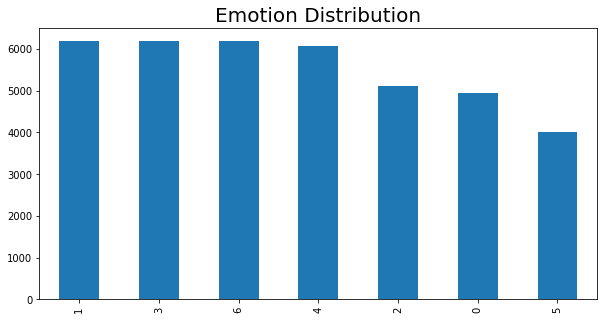

In [29]:
data['emotion'].value_counts().plot.bar(figsize=(10,5))
plt.title('Emotion Distribution',fontsize=20)

In [30]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


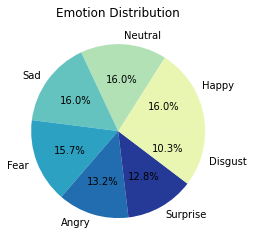

In [31]:
emotions_pie = {3: 'Happy',6: 'Neutral',  4: 'Sad', 2: 'Fear',0: 'Angry',   5: 'Surprise',1: 'Disgust' }

import seaborn as sns
colors = sns.color_palette('YlGnBu')
plt.pie(data['emotion'].value_counts(), 
      labels = emotions_pie.values(), 
        autopct = '%1.1f%%',
       # startangle =90,
        colors=colors
        )
plt.title('Emotion Distribution')
plt.show()


In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

##**Calculating Image Size**

In [33]:

import math
math.sqrt(len(data.pixels[0].split(' ')))

48.0

##**Normalization**

In [34]:
img = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img = np.stack(img, axis=0)

In [35]:
img.shape

(38747, 48, 48, 1)

In [36]:
le = LabelEncoder()
labels = le.fit_transform(data.emotion)
labels = np_utils.to_categorical(labels)
labels.shape

(38747, 7)

##**Spliting Dataset**

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(img, labels,
                                                    shuffle=True, stratify=labels,
                                                    test_size=0.3, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((27122, 48, 48, 1), (11625, 48, 48, 1), (27122, 7), (11625, 7))

In [76]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [77]:
X_train_RGB = np.repeat(X_train, repeats=3, axis=3)
X_valid_RGB = np.repeat(X_valid, repeats=3, axis=3)


##**Data Augmentation**

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

##**VGG16 Model**

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape = (48, 48, 3), include_top = False, weights = 'imagenet')

base_model.trainable = False

tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
np.random.seed(7)
tf.random.set_seed(7)

model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.50),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.15),
    Dense(7, activation='softmax')])

model.summary()

In [79]:
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.000001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time

history = model.fit(
    X_train_RGB,y_train,
    steps_per_epoch=len(X_train_RGB) / 64,
    epochs=200,
    validation_data=(X_valid_RGB,y_valid),
    validation_steps=len(X_valid_RGB) / 64,
    verbose=1)

##**Checkpoint and EarlyStopping**

In [62]:
checkpoint = ModelCheckpoint('model.h5',monitor='val_accuracy',save_best_only=True,mode='auto',verbose=1)


earlystop = EarlyStopping(monitor='val_accuracy',patience=5,mode='auto',verbose=1)


reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)

##**CNN Sequentioal Model**

In [ ]:
input_shape = (48, 48, 1)
output_class = 7
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))


model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

In [ ]:
plot_model(model, to_file = 'CNN Sequentioal Model.png', show_shapes = True, show_layer_names = True)

In [58]:
%%time
history = model.fit(x=X_train, y=y_train, 
                    batch_size=128, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/100
212/212 [==============================] - ETA: 0s - loss: 2.2214 - accuracy: 0.2515
Epoch 1: val_accuracy improved from -inf to 0.35277, saving model to model.h5
212/212 [==============================] - 23s 91ms/step - loss: 2.2214 - accuracy: 0.2515 - val_loss: 1.7197 - val_accuracy: 0.3528 - lr: 0.0010
Epoch 2/100
212/212 [==============================] - ETA: 0s - loss: 1.6402 - accuracy: 0.3816
Epoch 2: val_accuracy improved from 0.35277 to 0.47037, saving model to model.h5
212/212 [==============================] - 17s 83ms/step - loss: 1.6402 - accuracy: 0.3816 - val_loss: 1.4184 - val_accuracy: 0.4704 - lr: 0.0010
Epoch 3/100
212/212 [==============================] - ETA: 0s - loss: 1.4490 - accuracy: 0.4541
Epoch 3: val_accuracy improved from 0.47037 to 0.51475, saving model to model.h5
212/212 [==============================] - 18s 83ms/step - loss: 1.4490 - accuracy: 0.4541 - val_loss: 1.2912 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 4/100
212/212 [==========

##**Checkpoint and EarlyStopping**

In [63]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=11,verbose=1,restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1)

callbacks = [early_stopping,lr_scheduler]


##**CNN Model with BatchNormalization**

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())    
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())      
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(y_train.shape[1],activation='softmax'))

model.compile(loss=categorical_crossentropy,optimizer=Adam(0.001),metrics=['accuracy'])
model.summary()
   

In [ ]:

plot_model(model, to_file = 'CNN Sequentioal Model with BatchNormalization.png', show_shapes = True, show_layer_names = True)

In [69]:
batch_size = 32 
epochs = 100


In [70]:
                         
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    #callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100
847/847 [==============================] - 27s 30ms/step - loss: 2.2196 - accuracy: 0.1876 - val_loss: 1.7903 - val_accuracy: 0.2934
Epoch 2/100
847/847 [==============================] - 23s 27ms/step - loss: 1.8391 - accuracy: 0.2573 - val_loss: 1.6472 - val_accuracy: 0.3695
Epoch 3/100
847/847 [==============================] - 25s 29ms/step - loss: 1.6900 - accuracy: 0.3449 - val_loss: 1.4479 - val_accuracy: 0.4467
Epoch 4/100
847/847 [==============================] - 24s 28ms/step - loss: 1.5409 - accuracy: 0.4104 - val_loss: 1.3478 - val_accuracy: 0.4988
Epoch 5/100
847/847 [==============================] - 25s 29ms/step - loss: 1.4482 - accuracy: 0.4515 - val_loss: 1.2692 - val_accuracy: 0.5236
Epoch 6/100
847/847 [==============================] - 23s 27ms/step - loss: 1.3737 - accuracy: 0.4834 - val_loss: 1.2897 - val_accuracy: 0.5277
Epoch 7/100
847/847 [==============================] - 25s 29ms/step - loss: 1.3180 - accuracy: 0.5093 - val_loss: 1.1220 - val_ac

##**Ploting the Accuracy**

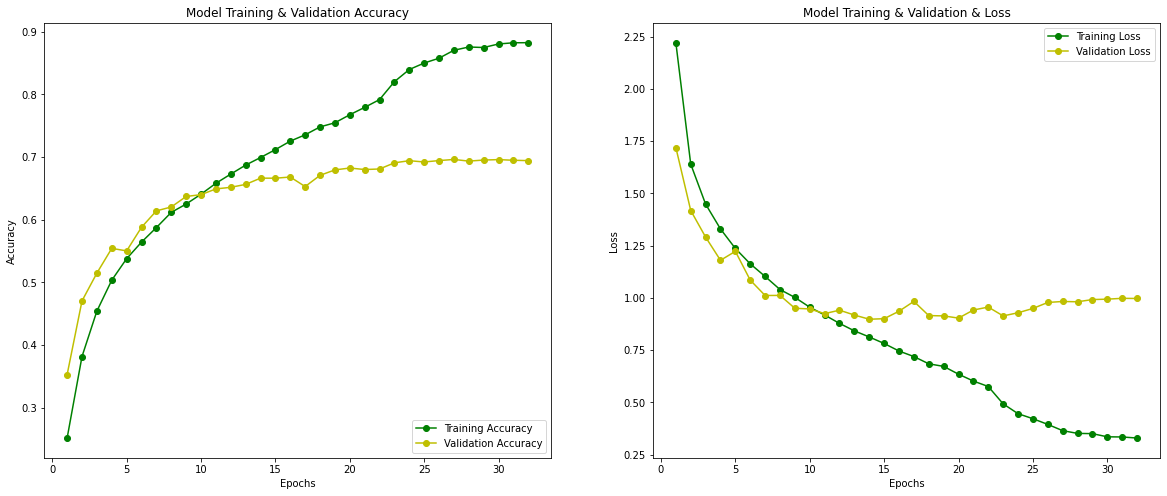

In [59]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [60]:
print('Train accuracy & loss:', model.evaluate(X_train,y_train))
print('\n')
print('Test accuracy & loss:', model.evaluate(X_valid,y_valid))

848/848 [==============================] - 7s 9ms/step - loss: 0.0882 - accuracy: 0.9817
Train accuracy & loss: [0.08822132647037506, 0.981675386428833]


364/364 [==============================] - 3s 9ms/step - loss: 0.9975 - accuracy: 0.6943
Test accuracy & loss: [0.9974737763404846, 0.6942795515060425]


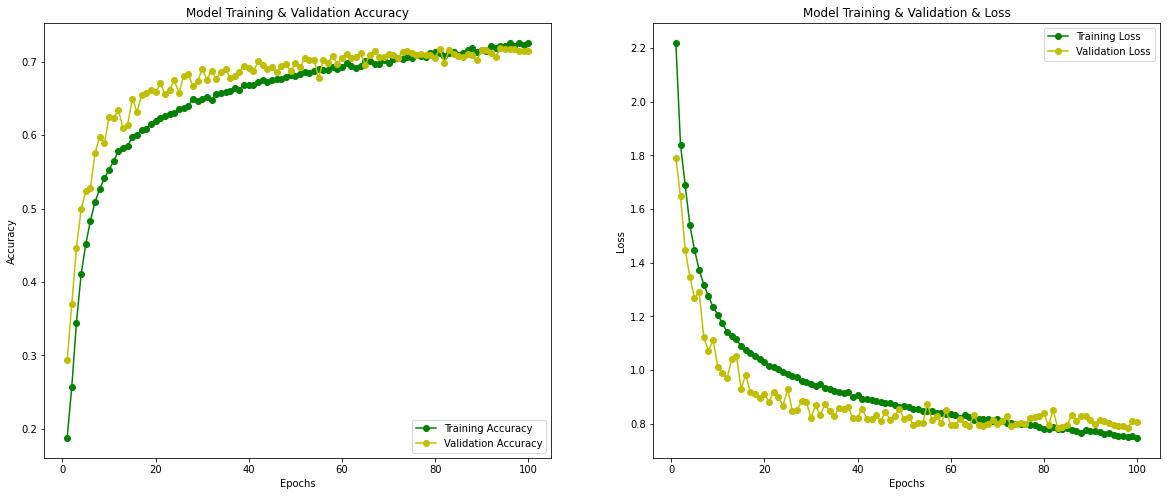

In [71]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [73]:
print('Train accuracy & loss:', model.evaluate(X_train,y_train))
print('\n')
print('Test accuracy & loss:', model.evaluate(X_valid,y_valid))

848/848 [==============================] - 7s 9ms/step - loss: 0.5278 - accuracy: 0.8069
Train accuracy & loss: [0.5278496146202087, 0.8068726658821106]


364/364 [==============================] - 3s 9ms/step - loss: 0.8050 - accuracy: 0.7151
Test accuracy & loss: [0.804966926574707, 0.7150967717170715]


In [ ]:
model.save("CNN_FER_model.h5")

In [ ]:
pred_labels = model.predict(X_valid)

In [ ]:
def Plot_Prediction(test_image_array, test_image_label, pred_test_labels, image_number):
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='green', alpha=0.7)
    axs[1].grid()
    print('Original Label:',(emotions[test_image_label[image_number]]))
    print('Predicted Label:',pred_test_labels[image_number])
    
    plt.show()

In [ ]:
Plot_Prediction(X_valid, y_valid, pred_labels, 188)
